# **Data Collection**
### Here below is the first step of our project, the code for our data collection. We've decided to scrap Wikipedia and Feedspots.

##### We'll start by listing all our import functions

In [ ]:
pip install
pip install matplotlib
pip install scikit-learn


In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from urllib.parse import urlparse
import time
import random
import csv
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter
import numpy as np
#nltk.download('punkt_tab') #: to uncomment if not already downloaded
#nltk.download('stopwords') #: to uncomment if not already downloaded
#nltk.download('wordnet')    #: to uncomment if not already downloaded
#nltk.download('omw-1.4')    #: to uncomment if not already downloaded

#### Below is a list of useful fonctions that will be used during the data collection.

##### The functions belows are used for the collect of links

Since we've encounter a lot of 403 error while collecting the html content. We therefore decided to randomize the headers.

In [33]:
HEADERS_POOL = [
    {'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"},
    {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36", "Accept-Language": "en-US,en;q=0.9", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8", "Referer": "https://www.google.com/"},
    {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:123.0) Gecko/20100101 Firefox/123.0", "Accept-Language": "en-US,en;q=0.9", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8", "Referer": "https://www.mozilla.org/"},
    {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 13_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.0 Safari/605.1.15", "Accept-Language": "en-gb,en;q=0.9", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "Referer": "https://www.apple.com/"},
    {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36 Edg/122.0.0.0", "Accept-Language": "en-US,en;q=0.9", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8", "Referer": "https://www.bing.com/"},
    {"User-Agent": "Mozilla/5.0 (iPhone; CPU iPhone OS 17_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.0 Mobile/15E148 Safari/604.1", "Accept-Language": "en-us,en;q=0.9", "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "Referer": "https://www.yahoo.com/"}
]

In [35]:
def fetch_verify_url(url) :
    try:
        session = requests.Session()
        session.headers.update(random.choice(HEADERS_POOL))
        response = session.get(url, timeout=10)
        #headers = random.choice(HEADERS_POOL)
        #response = requests.get(url, headers=headers, timeout = 10)
        if response.status_code != 200:  # If the status code is not OK (200) the function return none and an error message
            print(f"Failed to fetch the url: {url} with status code {response.status_code}")
            return None
        return response  
    except requests.RequestException:
        return None

This function is used to safely retrieve the HTML content of a web page. It sends an HTTP request to a given URL while mimicking a real web browser by specifying a User-Agent header, which helps avoid blocking by some websites. The function then checks whether the server responds with a successful status code (200). If the request fails, the page is inaccessible, or any network error occurs, the function returns None. Otherwise, it returns the raw HTTP response containing the page’s HTML content.

In [11]:
def to_soup(url):
    response = fetch_verify_url(url)
    if response:  # If the response is not none, the function return the beautiful soup object
        return BeautifulSoup(response.text, 'html.parser') 
    else:
        return None

This function converts the HTML content of a web page into a structured object that can be easily analyzed. It first calls the fetch_verify_url function to retrieve the web page’s HTML content. If the request is successful, the HTML is parsed using BeautifulSoup with the built-in HTML parser, producing a navigable representation of the page. If the page cannot be retrieved, the function returns None.

In [1]:
def filter_links(links, required_keywords=None, domain=None, already_seen=None):
    if required_keywords is None:  # If no list of required keywords is given then we create an empty one
        required_keywords = []
    if already_seen is None:  # If no list of already seen links is given then we create an empty one
        already_seen = set()
    
    filtered = []
    for l in links:
        l_lower = l.lower()  # Transformation of capital letter into lower case letter
        if required_keywords and not any(keyword.lower() in l_lower for keyword in required_keywords):  # The function skip the url if no required keywords are in the url
            continue
        if domain and urlparse(l).netloc != domain:  # The function filter the links that are not in the domain
            continue
        if l in already_seen:  # The function filter the links already in the list of links
            continue
        filtered.append(l) # If the url past all the filter, it is added to the list of links
    return filtered

This function filters a list of URLs in order to keep only the most relevant web pages. It removes links that doesn't contain predefined required keywords. The function can also restrict the results to a specific domain, allowing only internal links to be kept. Additionally, it eliminates URLs that have already been encountered, preventing duplicates during the crawling process.

By applying these filters, the function helps reduce noise and improves the quality and relevance of the collected dataset.

The functions below are used to collect the corpus of web pages

In [2]:
def get_html_content(links):
    content = []

    for link in links:
        response = fetch_verify_url(link)
        if response:
            content.append({'url': link, 'html': response.text}) # A dictionary with the url (as the key) and the corpus is created
        time.sleep(random.uniform(1,4))

    return content

This function collects the raw HTML content of a list of web pages.
It iterates over each URL in the input list, sends an HTTP request using the fetch_verify_url function, and checks whether the request was successful.
If a valid response is received, the function stores the page URL and its HTML source code as a dictionary and appends it to the corpus list.
A random delay between 1 and 4 seconds is added after each request to avoid overloading the server and to reduce the risk of being blocked.
Finally, the function returns the complete corpus containing the HTML content of all successfully fetched pages.

In [3]:
def save_to_csv(data, filename):
    if not data:
        print("Error : There is no data to save")
        return

    fieldnames = data[0].keys()  # Detection of the existing colons in the data file

    with open(filename, 'w', newline='', encoding='utf-8') as f:  # Opens the csv file as utf-8
        writer = csv.DictWriter(f, fieldnames=fieldnames, quoting=csv.QUOTE_ALL)  # Initialising a writer to write the dictionary into the csv file
        writer.writeheader()  # writes the colons headers
        writer.writerows(data)  # writes the rows

    print(f"CSV saved : {filename}")

This function saves a list of dictionaries into a CSV file.
It first checks whether the input data is empty; if no data is provided, the function prints an error message and stops execution.
The column names of the CSV file are automatically extracted from the keys of the first dictionary in the list.
The function then opens (or creates) the CSV file in UTF-8 encoding and initializes a DictWriter to correctly map dictionary keys to CSV columns.
The header row is written first, followed by all rows of data.
Finally, a confirmation message is printed to indicate that the CSV file has been successfully saved.

In [4]:
def clean_html(html):
    soup = BeautifulSoup(html, 'html.parser')

    for tag in soup(['script', 'style', 'noscript']):  # Supress any unessecary tags
        tag.decompose()

    text = soup.get_text(separator=' ', strip=True)  # Collect all visible text
    text = re.sub(r'\s+', ' ', text)  # Supress any unecessary spaces

    return text

This function cleans raw HTML content and extracts only the meaningful textual information.
First, the HTML string is parsed into a BeautifulSoup object, which allows structured navigation of the document.
All non-textual and irrelevant elements such as script, style, and noscript tags are then removed to avoid including code or hidden content in the final text.
The function extracts all visible text from the cleaned HTML, using spaces as separators and trimming unnecessary leading and trailing whitespace.
Finally, multiple consecutive spaces are reduced to a single space to produce a clean and readable text output.

In [5]:
def clean_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'corpus_text' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The corpus column is missing in: {input_csv}")

    df['cleaned_text'] = df['corpus_text'].apply(clean_html)  # Cleans the html column
    df = df[['url', 'cleaned_text']]  # Keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

This function cleans an entire CSV file containing raw HTML content.
First, the CSV file is loaded into a pandas DataFrame, allowing efficient column-wise processing.
The function checks whether the column named html exists; if it is missing, an error is raised to prevent silent failures and ensure data consistency.
Each HTML document in the html column is then cleaned using the clean_html function, and the resulting plain text is stored in a new column called cleaned_text.
Only the relevant columns (url and cleaned_text) are retained, discarding the original raw HTML to reduce file size and complexity.
Finally, the cleaned data is saved into a new CSV file, producing a structured and reusable text corpus for downstream processing.

In [6]:
def normalize_html(text):
    text = text.lower()  # convert all letters to lowercase
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers like [1], [2], etc.
    text = re.sub(r'\d+', ' ', text)  # remove all numbers
    text = re.sub(r'[^a-z\s]', ' ', text)  # keep only English letters and spaces
    text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with a single space
    return text.strip()  # remove leading and trailing spaces

This function performs text normalization on cleaned HTML content in order to prepare it for linguistic analysis.
First, all characters are converted to lowercase to ensure case-insensitive processing and avoid treating the same word as different tokens.
Reference markers such as [1], [2], commonly found in Wikipedia-style pages, are removed using a regular expression.
All characters that are not lowercase English letters, digits, or spaces are then replaced with spaces, effectively removing punctuation and special symbols.
Multiple consecutive spaces are collapsed into a single space to produce a cleaner and more consistent text format.
Finally, leading and trailing spaces are removed before returning the normalized text, ensuring uniform formatting across documents.

In [7]:
def normalize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the cleaned text as the input

    if 'cleaned_text' not in df.columns:  # Verify that the cleaned text colon exists
        raise ValueError(f"The cleaned text is missing in: {input_csv}")

    df['normalized_text'] = df['cleaned_text'].apply(normalize_html)  # normalize the cleaned text
    df = df[['url', 'normalized_text']]  # keep the url and normalized text 

    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

This function applies text normalization to an entire CSV file containing cleaned textual data.
First, the input CSV file is loaded into a pandas DataFrame. The function then checks whether the column cleaned_text exists to ensure that the expected input data is available. If the column is missing, a descriptive error is raised to prevent silent failures.
The normalization process is applied to each row of the cleaned_text column using the normalize_html function, producing a new column called normalized_text.
Only the URL and the normalized text columns are retained, as the raw and intermediate data are no longer needed at this stage.
Finally, the resulting DataFrame is saved to a new CSV file, which serves as the normalized version of the corpus and can be reused in subsequent processing steps.

In [ ]:
stop_words = list(set(stopwords.words('english'))) + ["'s"]
#stem = nltk.stem.SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def tokenize_html(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = filter_pos(tokens)
    tokens = [token for token in tokens if token not in string.punctuation]  # remove punctuation
    tokens = [token for token in tokens if token not in stop_words]  # remove stopwords
    #tokens = [stem.stem(token) for token in tokens]  # apply stemming (racinisation)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # apply lemmatization
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return tokens

This part of the code prepares and tokenizes normalized text for linguistic analysis.
First, a list of English stopwords is created using NLTK’s predefined stopword list, with the additional removal of the possessive form ’s, which often appears in English texts but carries little semantic value.
A Snowball stemmer configured for English is then initialized to reduce words to their root form.

The tokenize_html function takes a text string as input and converts it to lowercase to ensure consistency. The text is then tokenized into individual words using NLTK’s tokenizer.
Punctuation tokens are removed, followed by the removal of stopwords to keep only meaningful terms.
Finally, stemming is applied to each remaining token, reducing inflected or derived words to a common base form.
The function returns a list of processed tokens, which can be directly used for further tasks such as frequency analysis, topic modeling, or vectorization.

In [13]:
def tokenize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the normalized text as the input

    if 'normalized_text' not in df.columns:  # Verify that the normalized text colon exists
        raise ValueError(f"The normalized text is missing in: {input_csv}")

    df['tokenized_text'] = df['normalized_text'].apply(tokenize_html)  # cleans the html colon
    df = df[['url', 'tokenized_text']]  # keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

This function applies tokenization to a CSV file containing normalized text.
It begins by loading the input CSV file into a pandas DataFrame. Before processing, the function checks whether the column normalized_text exists; if not, it raises an error to prevent incorrect execution of the pipeline.

The function then applies the tokenize_html function to each row of the normalized_text column. This step transforms each text into a list of cleaned and stemmed tokens.
Only the URL and the resulting tokenized text are kept in the final DataFrame to reduce unnecessary data.

Finally, the processed data is saved into a new CSV file, producing a structured and reusable representation of the tokenized corpus that can be used for further text analysis tasks.

# ----------------------------------------------------------------------------------------------------------

#### We'll start by analysing the lifestyle Wikipedia page.

We start by scrapping the Wikipedia lifestyle page

In [14]:
url_wiki = "https://en.wikipedia.org/wiki/Lifestyle"

soup = to_soup (url_wiki)

if not soup:
    print("Error: Could not fetch Wikipedia page:", url_wiki)
    exit()

links_wiki = []

wiki = soup.find_all('div', class_="mw-content-ltr mw-parser-output")  # Make sure that only the links related to the page lifestyle is scrapped

for div in wiki:
    for p in div.find_all('p'):
        for item in p.find_all('a', href = True):
            href = item.get('href')
            if href.startswith("/wiki/") and ":" not in href:
                links_wiki.append(urljoin(url_wiki, href))

see_also = soup.find_all('div', class_='div-col')  # Collection of links that are in the "see also" section of the page

for div in see_also :
    for li in div.find_all('li'):
        for item in li.find_all('a', href = True):
                href = item.get('href')
                full_url = urljoin(url_wiki, href)
                if href.startswith("/wiki/") and ":" not in href and full_url not in links_wiki :
                    links_wiki.append(full_url)

print(len(links_wiki), "wikipedia pages has been found")
print("Pages founded:", links_wiki)


48 wikipedia pages has been found
Pages founded: ['https://en.wikipedia.org/wiki/Culture', 'https://en.wikipedia.org/wiki/Style_of_life', 'https://en.wikipedia.org/wiki/German_language', 'https://en.wikipedia.org/wiki/Alfred_Adler', 'https://en.wikipedia.org/wiki/Demographics', 'https://en.wikipedia.org/wiki/Metropolis', 'https://en.wikipedia.org/wiki/Neighborhood', 'https://en.wikipedia.org/wiki/Surf_culture', 'https://en.wikipedia.org/wiki/World_view', 'https://en.wikipedia.org/wiki/Self-concept', 'https://en.wikipedia.org/wiki/Symbol', 'https://en.wikipedia.org/wiki/Green_lifestyle', 'https://en.wikipedia.org/wiki/Ecological_footprint', 'https://en.wikipedia.org/wiki/Modernity', 'https://en.wikipedia.org/wiki/Thorstein_Veblen', 'https://en.wikipedia.org/wiki/Max_Weber', 'https://en.wikipedia.org/wiki/Georg_Simmel', 'https://en.wikipedia.org/wiki/Pierre_Bourdieu', 'https://en.wikipedia.org/wiki/Alfred_Adler', 'https://en.wikipedia.org/wiki/Milton_Rokeach', 'https://en.wikipedia.org/w

We then save the corpus (raw html) of all the pages scrapped in a csv file

In [15]:
links_wiki_total = ["https://en.wikipedia.org/wiki/Lifestyle"] # start with the main wikipedia page

# add links
for link in links_wiki:
    links_wiki_total.append(link)

# remove links
links_wiki_total = [link for link in links_wiki_total if "German_language" not in link and "Alfred_Adler" not in link and "Thorstein_Veblen" not in link and "Max_Weber" not in link and "Georg_Simmel" not in link and "Pierre_Bourdieu" not in link and "Milton_Rokeach" not in link and "Arnold_Mitchell" not in link and "Lynn_R._Kahle" not in link and "Daniel_Yankelovich" not in link and "Anthony_Giddens" not in link and "Richard_Jenkins" not in link and "William_Dufty" not in link and "Theodor_W._Adorno" not in link and "William_Dufty" not in link and "Market_segmentation" not in link] 

print(len(links_wiki_total), "Wikipedia pages is scrapped")
print("Final list of all Wikipedia pages to mine:", links_wiki_total)

33 Wikipedia pages is scrapped
Final list of all Wikipedia pages to mine: ['https://en.wikipedia.org/wiki/Lifestyle', 'https://en.wikipedia.org/wiki/Culture', 'https://en.wikipedia.org/wiki/Style_of_life', 'https://en.wikipedia.org/wiki/Demographics', 'https://en.wikipedia.org/wiki/Metropolis', 'https://en.wikipedia.org/wiki/Neighborhood', 'https://en.wikipedia.org/wiki/Surf_culture', 'https://en.wikipedia.org/wiki/World_view', 'https://en.wikipedia.org/wiki/Self-concept', 'https://en.wikipedia.org/wiki/Symbol', 'https://en.wikipedia.org/wiki/Green_lifestyle', 'https://en.wikipedia.org/wiki/Ecological_footprint', 'https://en.wikipedia.org/wiki/Modernity', 'https://en.wikipedia.org/wiki/Consumer_behaviour', 'https://en.wikipedia.org/wiki/Healthy_lifestyle', 'https://en.wikipedia.org/wiki/Style_(aesthetics)', 'https://en.wikipedia.org/wiki/Mass_media', 'https://en.wikipedia.org/wiki/Media_culture', 'https://en.wikipedia.org/wiki/Advanced_capitalism', 'https://en.wikipedia.org/wiki/Hyperm

In [16]:
content = get_html_content(links_wiki_total)

Failed to fetch the url: https://en.wikipedia.org/wiki/Demographics with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Neighborhood with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Self-concept with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Green_lifestyle with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Ecological_footprint with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Consumer_behaviour with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Healthy_lifestyle with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Advanced_capitalism with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Alternative_lifestyle with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Intentional_living with status code 403
Failed to fetch the url: https://en.wikipedia.org/wiki/Life_stance

In [17]:
save_to_csv(content, "wikipedia_lifestyle_content.csv")

CSV saved : wikipedia_lifestyle_content.csv


And we transform the csv file into a dataframe pandas to help us manipulate the table

In [18]:
df = pd.read_csv('wikipedia_lifestyle_content.csv')  # df is now a table 

Next, we keep only the corpus that intersts us (the content of the Wikipedia article without any html tags, ...) and save it in a csv file.

In [29]:
def get_corpus(html):
    soup = BeautifulSoup(html, "html.parser")

    corpus = soup.select_one("#mw-content-text")  # Select only what insterest us (the content of the Wikipedia article)
    if corpus is None:
        return []
    
    paragraphs = [p.get_text(separator=" ", strip=True) for p in corpus.find_all("p") if len(p.get_text(strip=True)) > 50]
    
    text = " ".join(paragraphs)

    return text

In [30]:
def corpus_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'html' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The html column is missing in: {input_csv}")

    df['corpus_text'] = df['html'].apply(get_corpus)  # Cleans the html column
    df = df[['url', 'corpus_text']]  # Keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

In [20]:
corpus_wiki_csv = corpus_csv_file("wikipedia_lifestyle_content.csv", "wikipedia_lifestyle_corpus.csv")

We then clean, normalize and tokenize the corpus stocked in the csv file. We save a new csv file at each step to track the changes done

###### Attention : in the function get_corpus we already transform the html in a soup object so we could take it out of the clean function but now we won't since it is a fucntion used for other urls

In [21]:
cleaned_wiki_csv = clean_csv_file("wikipedia_lifestyle_corpus.csv", "cleaned_wikipedia_lifestyle_corpus.csv")

In [22]:
normalized_wiki_csv = normalize_csv_file("cleaned_wikipedia_lifestyle_corpus.csv", "normalized_wikipedia_lifestyle_corpus.csv")

In [23]:
tokenized_wiki_csv = tokenize_csv_file("normalized_wikipedia_lifestyle_corpus.csv", "tokenized_wikipedia_lifestyle_corpus.csv")

We can now construct the term-document matrix. The dimension is already reduced. Indeed, during the normalization, the text has been set in lower case letter, the ponctuations was eliminated as were numbers. The stopwords were eliminated during the tokenization process.

In [24]:
def build_term_document_matrix(documents, min_doc_freq=2, max_doc_freq=None):
    # Step 1: Build a vocabulary (unique terms across all documents)
    vocabulary = set(token for tokens in documents.values() for token in tokens)

    # Step 2: Count term frequencies for each document
    term_frequencies = {doc: Counter(tokens) for doc, tokens in documents.items()}

    # Step 3: Construct the term-document matrix
    td_matrix = pd.DataFrame(
        {term: [term_frequencies[doc].get(term, 0) for doc in documents] for term in vocabulary},
        index = documents.keys()
    )

    # Step 4: Filter terms that appear in fewer / more than x documents
    document_frequency = (td_matrix > 0).sum(axis=0)

    if min_doc_freq is not None:
        td_matrix = td_matrix.loc[:, document_frequency >= min_doc_freq]

    if max_doc_freq is not None:
        document_frequency = (td_matrix > 0).sum(axis=0)
        td_matrix = td_matrix.loc[:, document_frequency <= max_doc_freq]

    vocabulary = td_matrix.columns.tolist()

    return td_matrix, vocabulary

In [25]:
tokenized_dict = dict(zip(tokenized_wiki_csv['url'], tokenized_wiki_csv['tokenized_text']))

In [39]:
wiki_td_matrix, wiki_vocab = build_term_document_matrix(tokenized_dict, min_doc_freq=5, max_doc_freq=20)

print(wiki_td_matrix)

                                                    live  engage  technology  \
https://en.wikipedia.org/wiki/Lifestyle                2       2           0   
https://en.wikipedia.org/wiki/Culture                  2       0           3   
https://en.wikipedia.org/wiki/Style_of_life            2       0           0   
https://en.wikipedia.org/wiki/Metropolis               0       0           0   
https://en.wikipedia.org/wiki/Surf_culture             3       2           1   
https://en.wikipedia.org/wiki/World_view               3       0           0   
https://en.wikipedia.org/wiki/Symbol                   3       0           0   
https://en.wikipedia.org/wiki/Modernity                0       0           1   
https://en.wikipedia.org/wiki/Style_(aesthetics)       0       0           1   
https://en.wikipedia.org/wiki/Mass_media               1       1           7   
https://en.wikipedia.org/wiki/Media_culture            0       1           0   
https://en.wikipedia.org/wiki/Hypermobil

We can now create the TF-IDF

In [40]:
row_sums = wiki_td_matrix.sum(axis=1)  # Total tokens per document (row)
tf = wiki_td_matrix.div(row_sums, axis=0)
df = (wiki_td_matrix > 0).sum(axis=0)  # Number of documents containing each term (column)
N = wiki_td_matrix.shape[0]  # Number of documents
idf = np.log((N) / (df))
tf_idf = tf.mul(idf, axis=1)
print(tf_idf)

                                                        live    engage  \
https://en.wikipedia.org/wiki/Lifestyle             0.001294  0.002394   
https://en.wikipedia.org/wiki/Culture               0.000399  0.000000   
https://en.wikipedia.org/wiki/Style_of_life         0.004597  0.000000   
https://en.wikipedia.org/wiki/Metropolis            0.000000  0.000000   
https://en.wikipedia.org/wiki/Surf_culture          0.000810  0.000999   
https://en.wikipedia.org/wiki/World_view            0.001997  0.000000   
https://en.wikipedia.org/wiki/Symbol                0.001639  0.000000   
https://en.wikipedia.org/wiki/Modernity             0.000000  0.000000   
https://en.wikipedia.org/wiki/Style_(aesthetics)    0.000000  0.000000   
https://en.wikipedia.org/wiki/Mass_media            0.000296  0.000548   
https://en.wikipedia.org/wiki/Media_culture         0.000000  0.001513   
https://en.wikipedia.org/wiki/Hypermobility_(tr...  0.000000  0.000000   
https://en.wikipedia.org/wiki/Anthropo

In [ ]:
We can then compute the similarity matrix

,https://en.wikipedia.org/wiki/Lifestyle,https://en.wikipedia.org/wiki/Culture,https://en.wikipedia.org/wiki/Style_of_life,https://en.wikipedia.org/wiki/Metropolis,https://en.wikipedia.org/wiki/Surf_culture,https://en.wikipedia.org/wiki/World_view,https://en.wikipedia.org/wiki/Symbol,https://en.wikipedia.org/wiki/Modernity,https://en.wikipedia.org/wiki/Style_(aesthetics),https://en.wikipedia.org/wiki/Mass_media,https://en.wikipedia.org/wiki/Media_culture,https://en.wikipedia.org/wiki/Hypermobility_(travel),https://en.wikipedia.org/wiki/Anthropology,https://en.wikipedia.org/wiki/Lifestyle_brand,https://en.wikipedia.org/wiki/Sedentary_lifestyle,https://en.wikipedia.org/wiki/Sustainable_living
https://en.wikipedia.org/wiki/Lifestyle,1.000000,0.183177,0.184769,0.037570,0.185232,0.117481,0.081753,0.144962,0.191999,0.121833,0.163710,0.045165,0.154060,0.638277,0.438810,0.178756
https://en.wikipedia.org/wiki/Culture,0.183177,1.000000,0.123327,0.112083,0.312637,0.343917,0.110941,0.426557,0.191324,0.196131,0.319523,0.097447,0.651771,0.129278,0.132520,0.234732
https://en.wikipedia.org/wiki/Style_of_life,0.184769,0.123327,1.000000,0.011612,0.104107,0.130263,0.023972,0.114884,0.638899,0.021540,0.058999,0.010288,0.118565,0.052507,0.044694,0.075905
https://en.wikipedia.org/wiki/Metropolis,0.037570,0.112083,0.011612,1.000000,0.128510,0.062070,0.026156,0.112246,0.040694,0.064387,0.031424,0.081571,0.186143,0.030811,0.093322,0.183073
https://en.wikipedia.org/wiki/Surf_culture,0.185232,0.312637,0.104107,0.128510,1.000000,0.190935,0.062187,0.236649,0.171071,0.203866,0.204635,0.170744,0.322995,0.167610,0.226646,0.278766
https://en.wikipedia.org/wiki/World_view,0.117481,0.343917,0.130263,0.062070,0.190935,1.000000,0.079358,0.293907,0.105326,0.110855,0.140895,0.096204,0.319266,0.093345,0.123197,0.134032
https://en.wikipedia.org/wiki/Symbol,0.081753,0.110941,0.023972,0.026156,0.062187,0.079358,1.000000,0.075887,0.035313,0.037867,0.045164,0.027044,0.105511,0.131792,0.026701,0.042887
https://en.wikipedia.org/wiki/Modernity,0.144962,0.426557,0.114884,0.112246,0.236649,0.293907,0.075887,1.000000,0.241662,0.190893,0.231485,0.088986,0.487856,0.106504,0.137787,0.228702
https://en.wikipedia.org/wiki/Style_(aesthetics),0.191999,0.191324,0.638899,0.040694,0.171071,0.105326,0.035313,0.241662,1.000000,0.051528,0.098222,0.040502,0.190049,0.047783,0.058598,0.089096
https://en.wikipedia.org/wiki/Mass_media,0.121833,0.196131,0.021540,0.064387,0.203866,0.110855,0.037867,0.190893,0.051528,1.000000,0.702830,0.084967,0.202631,0.055919,0.118987,0.134497


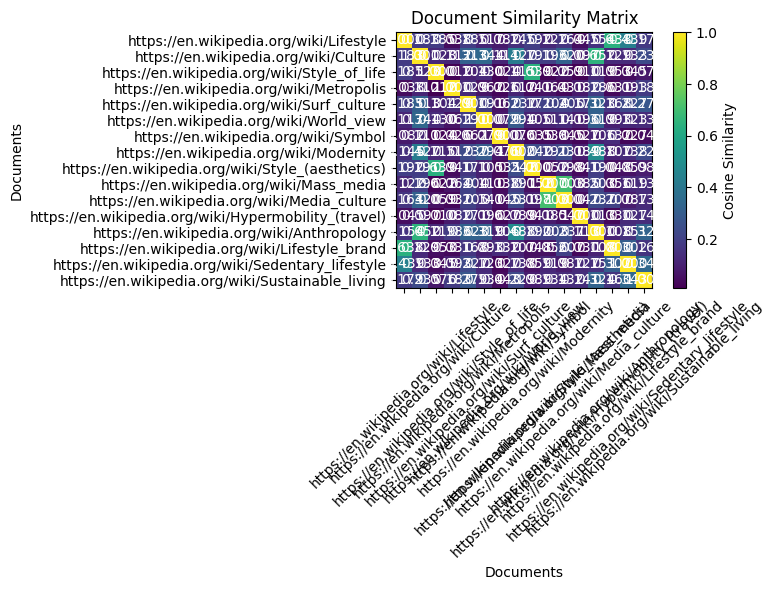

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity_matrix_tfidf = cosine_similarity(tf_idf)

# Convert to a DataFrame for better readability (optional)
similarity_df_tfidf = pd.DataFrame(similarity_matrix_tfidf, index=tf_idf.index, columns=tf_idf.index)

# Display the similarity DataFrame
display(similarity_df_tfidf)

def plot_similarity_matrix(similarity_df):
    # Plot the similarity matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_df, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Similarity Matrix')
    plt.xticks(ticks=range(len(similarity_df.columns)), labels=similarity_df.columns, rotation=45)
    plt.yticks(ticks=range(len(similarity_df.index)), labels=similarity_df.index)
    plt.xlabel('Documents')
    plt.ylabel('Documents')

    # Optionally, annotate the cells with similarity values
    for i in range(len(similarity_df)):
        for j in range(len(similarity_df)):
            plt.text(j, i, f"{similarity_df.iloc[i, j]:.3f}", ha='center', va='center', color='white')

    plt.tight_layout()

plot_similarity_matrix(similarity_df_tfidf)

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# Load corpus
df = pd.read_csv("normalized_wikipedia_lifestyle_corpus.csv")
documents = df["normalized_text"].astype(str).tolist()
documents = [d for d in documents if len(d.split()) > 100]  # remove documents with less than a 100 words (they are too short and only makes noise)

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # It transforms every document in a vector which have meaning 

# Vectorizer
vectorizer_model = CountVectorizer(
    stop_words="english",
    min_df=3,
    ngram_range=(1, 2)
)

# KMeans clustering (NO hdbscan)  -> clustering of documents per topic (we can ask for x cluster)
cluster_model = KMeans(
    n_clusters=6,
    random_state=42,
    n_init="auto"
)

# BERTopic without hdbscan
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=cluster_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents)

print(topic_model.get_topic_info())

# ----------------------------------------------------------------------------------------------------------

##### Following that, we can start the data collection with the scraping of Feedspots.

In [ ]:
url_blogs = "https://bloggers.feedspot.com/lifestyle_blogs/"

soup = to_soup(url_blogs)

if not soup:
    print("Error: Could not fetch main blogs page:", url_blogs)

blogs = soup.find_all(lambda tag: tag.name in ['a', 'span'] and tag.get('class') and 'wb-ba' in tag.get('class') and any('ext' in c for c in tag.get('class')))

links_blogs = []
for item in blogs:
    href = item.get('href') if item.name == 'a' else item.text.strip()
    if href and "http" in href and "bloggers.feedspot.com" not in href:  # Exclusion of internal links to only extract links directing to blogs
        links_blogs.append(href)

print(len(links_blogs), "blogs has been found")
print("Blogs founded:", links_blogs[:1])

Status: 200
100 blogs has been found
Blogs founded: ['https://www.mindbodygreen.com/', 'https://www.thepioneerwoman.com/', 'https://goop.com/', 'https://www.artofmanliness.com/', 'https://www.themarthablog.com/', 'https://sincerelyjules.com/', 'https://www.pbfingers.com/', 'https://camillestyles.com/', 'https://cupofjo.com/', 'https://www.theskinnyconfidential.com/', 'https://www.apetogentleman.com/', 'https://www.primermagazine.com/', 'https://livinginyellow.com/', 'https://www.ahealthysliceoflife.com/', 'https://onbetterliving.com/', 'https://thestripe.com/', 'https://helloadamsfamily.com/', 'https://julieblanner.com/', 'https://heleneinbetween.com/', 'https://inspirationsandcelebrations.net/', 'https://www.elizabethrider.com/', 'https://www.katiedidwhat.com/', 'https://www.idyllicpursuit.com/', 'https://witwhimsy.com/', 'https://happilyevaafter.com/', 'https://theblueridgegal.com/', 'https://lmgfl.com/', 'https://simplytaralynn.com/', 'https://socialifestylemag.com/', 'https://www.l

This code retrieves a curated list of lifestyle blogs from the Feedspot website. It first loads and parses the HTML content of the Feedspot page containing the blog rankings. If the page cannot be accessed, the program stops to prevent further errors. The code then identifies the HTML elements corresponding to blog links by targeting specific tags and CSS classes used by Feedspot.

For each identified element, the script extracts the blog URL and filters out internal Feedspot links, keeping only external blog websites. The resulting list contains the URLs of lifestyle blogs, which serve as the starting points (seed URLs) for the subsequent crawling process. Finally, the script reports the number of blogs successfully collected and displays a sample of the extracted URLs.

In [ ]:
def get_links_from_blog(url):
    soup = to_soup(url)
    if not soup:
        return None
    
    links = []
    for link in soup.find_all("a"):
        href = link.get("href")
        if not href:
            continue
        # gérer les liens relatifs (/about → https://blog.com/about)
        full_url = urljoin(url, href)
        if full_url.startswith("http") and full_url not in links:
            links.append(full_url)

    return links


This function extracts all hyperlinks from a given web page. It first retrieves and parses the HTML content of the page using the to_soup function. If the page cannot be accessed, the function returns None. The function then scans all anchor (<a>) elements and extracts their href attributes. Relative URLs are converted into absolute URLs using the base page URL to ensure consistency.

Only valid HTTP links are kept, and duplicate URLs are removed. The function returns a list of unique hyperlinks found on the page, which are later used in the crawling process.

In [ ]:

exclude_keywords = [
    "privacy",       
    "contact",      
    "terms",       
    "login",      
    "signup",      
    "register",    
    "tag",       
    "category",   
    "archive",       
    "feed",     
    "comments",    
    "search",        
    "newsletter",    
    "cart",          
    "checkout",     
    "admin",        
    "wp-",  
    "cgi-bin",
    "privacy-policy",
    "cookie",
    "sitemap",
    "login.php", 
    "register.php", 
    "unsubscribe", 
    "terms-of-service",
    "press",    
    "ad",   
    "ads",  
    "advertisement", 
    "accessibility",  
    "sponsor",
    "disclaimer",
]

A list of exclusion keywords is defined to remove non-relevant web pages from the crawling process. These keywords correspond to administrative, legal, technical, or commercial pages such as privacy policies, contact forms, login pages, archives, tags, advertisements, and sponsored content. By filtering out URLs containing these terms, the crawler focuses on pages that are more likely to contain meaningful blog content, reducing noise in the collected dataset.

In [ ]:
links_in_blogs_1 = {}

total_new_urls_1 = 0

for url in links_blogs[:2]:  # scrappe les x premiers blogs et retourne le nombre de lien trouvé sur la page d'accueil et les 5 premiers liens
    print("\nLinks from the blog (first round):", url)

    links = get_links_from_blog(url)
    if links is None:
        print("→ 0 links found (scraping failed or blocked)")
        links_in_blogs_1[url] = []
        continue

    domain = urlparse(url).netloc
    filtered_links = filter_links(links, exclude_keywords=exclude_keywords, domain=domain, already_seen=set())

    links_in_blogs_1[url] = filtered_links

    total_new_urls_1 += len(filtered_links)

    print("→", len(filtered_links), "links found:", filtered_links[:1])

    time.sleep(1)

print("Total new URLs found in this first round iteration:", total_new_urls_1)

In the first crawling round, the script visits the homepages of a subset of selected blogs and extracts all hyperlinks present on each page. The collected links are then filtered using predefined exclusion keywords to remove non-content pages. Additionally, the filtering process is restricted to the same domain as the source blog in order to retain only internal links. The resulting URLs are stored in a dictionary and counted to measure the number of relevant pages identified during this initial crawling stage.